In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score


from sklearn.linear_model import LinearRegression
%matplotlib inline

pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000

In [440]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

---
# Relevant Helper Funcitons

In [441]:
#function to create a dataframe of specific characteristics
def character_df(dataframe):
    ''' Argument: dataframe= 'whatever data frame you select'   ,
    This function returns a dataframe of null counts per column, percent missing, and if categorical its unique values.
    '''
    #create a column of null counts per feature
    isnull_cnt    = dataframe.isnull().sum()
    only_isnull_cnt=[isnull_cnt[null_cnt] for null_cnt in range(len(isnull_cnt))]

    #create a column of percentage missing per features
    prct_missing = round(dataframe.isnull().sum() * 100 / len(dataframe),2)
    only_prct=[prct_missing[percent] for percent in range(len(prct_missing))]

    # create a column that lists different variables held within categorical variables 
    cat_list=[dataframe[column].unique() if str( dataframe[column].dtype )=='object' else 'not cat.'  for column in dataframe  ]

    #create a df from all the series outputed above
    df_characteristics = pd.DataFrame({'column_name':dataframe.columns ,'null_count': only_isnull_cnt, 'percent_missing': only_prct, 'categorical_unique': cat_list})

    return df_characteristics

df_charac=character_df(df_train)   
df_charac.head(4)

,column_name,null_count,percent_missing,categorical_unique
0,Id,0,0.0,not cat.
1,PID,0,0.0,not cat.
2,MS SubClass,0,0.0,not cat.
3,MS Zoning,0,0.0,"[RL, RM, FV, C (all), A (agr), RH, I (all)]"


Note: The above function was built off inspiration from a more visually appealing percent formula that I was constantly creating so created this function so I can easily just filter based on characteristics I was most interested. I will use this data frame while I perform EDA. [Stack Overflow Inspiration-'find percent missing values'](https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset)



*******

In [396]:
# following code is just to aid in explaination of function fillna_centrl_tendcy
Lot_prac_df = df_train.copy()
lot_series = Lot_prac_df['Lot Frontage'].groupby(Lot_prac_df['Lot Config']).mean()
print(lot_series)


Lot Config
Corner     83.245552
CulDSac    55.228571
FR2        60.836735
FR3        87.000000
Inside     66.952780
Name: Lot Frontage, dtype: float64


In [420]:
# Original Code Inspiration df['z'].fillna(dff.groupby('x')['z'].transform('mean'))
# A function to utilize fillna and transform function to quickly replace NaN values within a dataframe
def fillna_centrl_tendcy(dataframe,change_column,groupby_column,function):
    '''
    Arguments: dataframe = df ,   change_column='column to change', groupby_column = 'column_name' , function = 'mean' 
    Note about Function: 
    Function to use for transforming the data. 
    If a function, must either work when passed a DataFrame or when passed to DataFrame.apply. If func is both list-like and dict-like, dict-like behavior takes precedence(from transform documentation).
    The function allows for easy fills of na given a dataframe, column to group by, and the function you want to perform('mean','mode','median'),'''
    dataframe[change_column] = dataframe[change_column].groupby( dataframe[groupby_column] ).transform(function)
    return dataframe 
Example_output = fillna_centrl_tendcy(dataframe=Lot_prac_df,change_column='Lot Frontage',groupby_column='Lot Config',function='mean')
Example_output.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,55.228571,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


The above function was created with an expectation that I would need to make some assumption of how to fill some of the NaN values within my data set. The function allows for easy fills of na given a dataframe, column to group by, and the function you want to perform('mean','mode','median'). A sample output was provided to show how it works.

In [470]:
# function to print out quick null summary details
def null_reminders(dataframe,column_name,features_to_drop,value_cnt):
    ''' dataframe = df, column_name = 'name', featires_to_drop = list of columns names not wanted , value_cnt=='Yes' 
    Note: returns a seperate dataframe
    '''
    # providing reminder of what needs to be replaced/filled
    print('is null sum: ',dataframe[column_name].isnull().sum() )
    
    #checking if value counts are wanted
    if value_cnt=='Yes':
        print(dataframe[column_name].value_counts() )

    #filter to peek at df potentially looking for a method to fill these 55 observations
    df_column_null = dataframe[   dataframe[column_name].isnull()   ].drop(columns=features_to_drop)
    print('df_column_ shape',df_column_null.shape)
    return df_column_null

---

# Data Cleaning and Exploration

In [421]:
print(df_train.shape)
df_train.head()

(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


After a quick inspection of the rain.csv file and my df_train it is clearly noteable that the 'NA' values were imported by pandas as a NaN value. However because of the magnitude of NA data for these respective rows I will still drop them since there is not much data to truly get a accurate respresentation of the feature as a whole. 

In [442]:
df_train.shape

(2051, 81)

In [443]:
df_charac=character_df(df_train)   
df_charac[df_charac['percent_missing']>40]

,column_name,null_count,percent_missing,categorical_unique
7,Alley,1911,93.17,"[nan, Pave, Grvl]"
58,Fireplace Qu,1000,48.76,"[nan, TA, Gd, Po, Ex, Fa]"
73,Pool QC,2042,99.56,"[nan, Fa, Gd, Ex, TA]"
74,Fence,1651,80.50,"[nan, MnPrv, GdPrv, GdWo, MnWw]"
75,Misc Feature,1986,96.83,"[nan, Shed, TenC, Gar2, Othr, Elev]"


The features listed below will be dropped because such a high percentage of these features are missing with exception to the 'PID' however for the purposes of these models I will not be utilizing the PID as a predictor. The replacement of NaNs with any method of central tendency would not yield a representative result. Additionally, after collaboration with David Coons and Hank Butler, the possibility to determine location and potentially relevance to a location of importance could be possible but will be too advanced for the purposes of this project. 
<br><br>

Features automatically to be dropped:
 ['Alley', 'Pool QC', 'Fence', 'Misc Feature', 'PID', 'Fireplace Qu'] 

In [444]:
df_train.drop(['Alley', 'Pool QC', 'Fence', 'Misc Feature', 'PID', 'Fireplace Qu'], axis =1, inplace = True)

--- 
##### Checking data types 
This subsection works through cleaning categorical variables to match the data dictionary entries

In [445]:
df_charac=character_df(df_train)   # dropped columns earlier so not a total of 81 features anymore
df_categorical=df_charac.drop(columns=['null_count','percent_missing'])
df_categorical.head()

,column_name,categorical_unique
0,Id,not cat.
1,MS SubClass,not cat.
2,MS Zoning,"[RL, RM, FV, C (all), A (agr), RH, I (all)]"
3,Lot Frontage,not cat.
4,Lot Area,not cat.


After a quick check from the categorical column above and the data dictionary I can see that there are some  Ordinal variables that are represented as categorical which will for the purposes of this analysis will be acceptable since there are only two variables if there were more a closer analysis of whether or not to treat them as categorical would be more appropriate. 
The following features were misrepresented:
- Overall Quality ('Overall Qual')
- Overall Condition ('Overall Cond')


--- 
##### Categorical Alterations
This subsection works through cleaning categorical variables to match the data dictionary entries

In [446]:
# will clean 'MS Zoning'  to match data dictionary entries
df_train['MS Zoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64

In [447]:
# the actual replacement implemented
df_train['MS Zoning'] = [df_train['MS Zoning'][i].replace('(all)',' ') for i in range(df_train.shape[0])]
df_train['MS Zoning'] = [df_train['MS Zoning'][i].replace('(agr)',' ') for i in range(df_train.shape[0])]

df_train['MS Zoning'].value_counts()

RL     1598
RM      316
FV      101
C        19
RH       14
A         2
I         1
Name: MS Zoning, dtype: int64

In [449]:
# None is an actual category in data dictionary so will not alter
df_train['Mas Vnr Type'].value_counts() 

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [450]:
# these are just features that are not relevant to basement quality stored to drop in filter
features_to_drop = ['Id', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street','Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope','Neighborhood', 'Condition 1',
 'Condition 2', 'Bldg Type','House Style', 'Overall Qual', 'Overall Cond', 'Year Built','Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st','Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 
'Exter Qual','Exter Cond', 'Foundation',  'Full Bath','Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual','TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF',
'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch','Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold' ]

In [451]:
# taking quick glance at null details
null_reminders(dataframe=df_train, column_name='Bsmt Qual',features_to_drop=features_to_drop).head()


is null sum:  55
TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64
df_column_ shape (55, 21)


,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Sale Type,SalePrice
12,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,1288,728,0,2016,0.0,0.0,WD,131000
93,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,1535,0,0,1535,0.0,0.0,WD,118858
114,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Fa,N,SBrkr,660,0,0,660,0.0,0.0,WD,63900
146,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,495,1427,0,1922,0.0,0.0,ConLD,198500
183,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,WD,13100


After some consideration noting that a lot of these houses probably did not have a basement (we an 'NA' in train.csv file) I feel comfortable just renaming these nulls with 'no basement' string so can be inputed into model after one-hot coding. Will do so below and then move onto next categorical variable inspection. 

In [457]:
# filling NaN values with 'no_basement' for columns = ['Bsmt Qual','Bsmt Cond','BsmtFin Type 2','Bsmt Exposure','BsmtFin Type 1']
columns2replace = ['Bsmt Qual','Bsmt Cond','BsmtFin Type 2','Bsmt Exposure','BsmtFin Type 1']

# performing replacement and verifying
for column in columns2replace:
    print(column)
    df_train[column] = df_train[column].fillna('no_basement')
    print('is null sum: ',df_train[column].isnull().sum() )
    print('') # just for break b/w loops

Bsmt Qual
is null sum:  0

Bsmt Cond
is null sum:  0

BsmtFin Type 2
is null sum:  0

Bsmt Exposure
is null sum:  0

BsmtFin Type 1
is null sum:  0



In [458]:
# second verification
null_reminders(dataframe=df_train, column_name='Bsmt Qual',features_to_drop=features_to_drop)


is null sum:  0
TA             887
Gd             864
Ex             184
Fa              60
no_basement     55
Po               1
Name: Bsmt Qual, dtype: int64
df_column_ shape (0, 10)


,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Yr Sold,Sale Type,SalePrice


Will repeat the same process for the following columns and colum names <br>
- Garage Type	        = [Attchd, Detchd, BuiltIn, Basment, nan, 2Types...<br>
- Garage Finish	    = [RFn, Unf, Fin, nan]<br>
- Garage Qual	        =[TA, Fa, nan, Gd, Ex, Po]<br>
- Garage Cond	        =[TA, Fa, nan, Po, Gd, Ex]<br>

In [456]:
# manually selected what features to isolate
features_to_drop = ['Id', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope','Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type','House Style', 'Overall Qual', 'Overall Cond', 'Year Built','Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st','Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual','Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure','BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air','Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath','Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual','TotRms AbvGrd', 'Functional', 'Fireplaces', 'Paved Drive', 'Wood Deck SF','Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch','Pool Area', 'Misc Val', 'Mo Sold',                                      ]

# quick glance at garage specific features
null_reminders(dataframe=df_train, column_name='Garage Type',features_to_drop=features_to_drop).head()


is null sum:  113
Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64
df_column_ shape (113, 10)


,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Yr Sold,Sale Type,SalePrice
28,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2007,WD,119600
53,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2010,WD,76000
65,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2007,New,147000
79,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2007,WD,129850
101,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2007,WD,86000


After revisting data dictionary noted that since the columns ['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond'] all appear to have missing values for each specific house it is likely they were originally 'NA' (No Garage) inputs on the train.csv so will replace them with the string 'no_garage' to have acurate dummy columns later on. 

In [460]:
# filling NaN values with 'no_basement' for columns = ['Bsmt Qual','Bsmt Cond','BsmtFin Type 2','Bsmt Exposure','BsmtFin Type 1']
columns2replace = ['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond']

# performing replacement and verifying
for column in columns2replace:
    print(column)
    df_train[column] = df_train[column].fillna('no_garage')
    print('is null sum: ',df_train[column].isnull().sum() )
    print('') # just for break b/w loops

# quick glance at garage specific features for confirmation
null_reminders(dataframe=df_train, column_name='Garage Type',features_to_drop=features_to_drop).head()

Garage Type
is null sum:  0

Garage Yr Blt
is null sum:  0

Garage Finish
is null sum:  0

Garage Qual
is null sum:  0

Garage Cond
is null sum:  0

is null sum:  0
Attchd       1213
Detchd        536
BuiltIn       132
no_garage     113
Basment        27
2Types         19
CarPort        11
Name: Garage Type, dtype: int64
df_column_ shape (0, 10)


,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Yr Sold,Sale Type,SalePrice


--- 
##### Continous Feature Alterations
This subsection works through cleaning continous variables to match the data dictionary entries based on logical assumptions. This section will focus on replace larger amounts of nulls at a time within a feature not those  with 1 null value. 

In [465]:
# getting a glimpse of what is left to work with
charac_df = character_df(df_train)
charac_df[ charac_df['null_count']>1 ]

,column_name,null_count,percent_missing,categorical_unique
3,Lot Frontage,330,16.09,not cat.
24,Mas Vnr Type,22,1.07,"[BrkFace, None, nan, Stone, BrkCmn]"
25,Mas Vnr Area,22,1.07,not cat.
46,Bsmt Full Bath,2,0.10,not cat.
47,Bsmt Half Bath,2,0.10,not cat.


In [471]:
# again manually selecting what columns I do not want to look at in my  reminder function
features_to_drop = [  'MS SubClass', 'MS Zoning', 
 'Overall Cond', 'Year Built','Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual','Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure','BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air','Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF','Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath','Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual','TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area','Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF','Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch','Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Sale Type']
df_lot_frnt = null_reminders(dataframe=df_train, column_name='Lot Frontage',features_to_drop=features_to_drop,value_cnt='No').head()
df_lot_frnt.head()

is null sum:  330
df_column_ shape (330, 16)


,Id,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,SalePrice
0,109,NaN,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,130500
7,145,NaN,12160,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,142000
8,1942,NaN,15783,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,112500
23,12,NaN,7980,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,185000
27,1534,NaN,11700,Pave,IR1,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,1Fam,1.5Fin,5,198000


For this particular feature since there are groups for each of these missing values the replacement of the average by group should be a decent estimate in case this feature is selected to be inputed into the model. 

In [472]:
#actual replacement of nulls
fillna_centrl_tendcy(dataframe=df_train,change_column='Lot Frontage',groupby_column='Lot Config',function='mean')

# checking output again to ensure no other nulls were left
df_lot_frnt = null_reminders(dataframe=df_train, column_name='Lot Frontage',features_to_drop=features_to_drop,value_cnt='No').head()
df_lot_frnt.head()

is null sum:  0
df_column_ shape (0, 16)


,Id,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,SalePrice


In [475]:
# again manually selecting what columns I do not want to look at in my reminder function
features_to_drop = [ 'Id', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope','Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type','House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st','Exterior 2nd','Exter Qual','Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure','BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath','Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type','Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area','Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch','Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Sale Type','SalePrice']


df_mas_vnr = null_reminders(dataframe=df_train, column_name='Mas Vnr Type',features_to_drop=features_to_drop,value_cnt='Yes')
df_mas_vnr.head()

is null sum:  22
None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64
df_column_ shape (22, 2)


,Mas Vnr Type,Mas Vnr Area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN


From the NaN in the Mas Vnr Area (Masonry veneer area in square feet) column I will assume that these houses did not have a Masonry at all. So these values will be fill with their respective None(Mas Vnr Type) and 0 square ft (Mas Vnr Area) values from the data dictionary. 

In [477]:
# performing replacement for  ['Mas Vnr Type']
columns2replace = ['Mas Vnr Type']
for column in columns2replace:
    df_train[column] = df_train[column].fillna('None')
    print('is null sum: ',df_train[column].isnull().sum() )
    print('') # just for break b/w loops

# performing replacement for  ['Mas Vnr Area']
columns2replace = ['Mas Vnr Area']
for column in columns2replace:
    df_train[column] = df_train[column].fillna(0)
    print('is null sum: ',df_train[column].isnull().sum() )
    print('') # just for break b/w loops

# quick glance at masonry specific features for confirmation
null_reminders(dataframe=df_train, column_name='Garage Type',features_to_drop=features_to_drop,value_cnt='Yes').head()

is null sum:  0

is null sum:  0

is null sum:  0
Attchd       1213
Detchd        536
BuiltIn       132
no_garage     113
Basment        27
2Types         19
CarPort        11
Name: Garage Type, dtype: int64
df_column_ shape (0, 2)


,Mas Vnr Type,Mas Vnr Area


In [493]:
# again manually selecting what columns I do not want to look at in my reminder function
features_to_drop = [ 'Id', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Heating'	,'Heating QC'	,'Central Air'	,'Electrical',	'1st Flr SF',	'2nd Flr SF',	'Low Qual Fin SF'	,'Gr Liv Area','Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope','Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type','House Style', 'Overall Qual', 'Overall Cond', 'Year Built','Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st','Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual','Exter Cond', 'Foundation','Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual','TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type','Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area','Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF','Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch','Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Sale Type','SalePrice']


df_bsmt_baths = null_reminders(dataframe=df_train, column_name='Bsmt Full Bath',features_to_drop=features_to_drop,value_cnt='Yes')
df_bsmt_baths.head()

is null sum:  2
0.0    1200
1.0     824
2.0      23
3.0       2
Name: Bsmt Full Bath, dtype: int64
df_column_ shape (2, 13)


,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath
616,no_basement,no_basement,no_basement,no_basement,0.0,no_basement,0.0,0.0,0.0,NaN,NaN,3,1
1327,no_basement,no_basement,no_basement,no_basement,NaN,no_basement,NaN,NaN,NaN,NaN,NaN,1,0


Clearly the NaN values within this data frame should all be replaced with 0 since there are no basements in these house observations. Hopefully this will take care of some of the random null values that would have had to be cleaned later on. In the data dictionary they are all either categorical or discrete so replacement with 0 seems to be accurate statements across the board if there are no basements.

In [494]:
# performing replacement for  ['BsmtFin SF 1','BsmtFin SF 2' ,'Bsmt Unf SF' ,'Total Bsmt SF', 'Bsmt Full Bath','Bsmt Half Bath']
columns2replace = ['BsmtFin SF 1','BsmtFin SF 2' ,'Bsmt Unf SF' ,'Total Bsmt SF', 'Bsmt Full Bath','Bsmt Half Bath']
for column in columns2replace:
    df_train[column] = df_train[column].fillna(0)
    print('is null sum: ',df_train[column].isnull().sum() )
    print('') # just for break b/w loops

# quick glance at bsmt specific features for confirmation
null_reminders(dataframe=df_train, column_name='BsmtFin SF 1',features_to_drop=features_to_drop,value_cnt='Yes').head()

is null sum:  0

is null sum:  0

is null sum:  0

is null sum:  0

is null sum:  0

is null sum:  0

is null sum:  0
0.0       658
24.0       17
16.0       10
20.0        7
384.0       7
300.0       7
368.0       6
360.0       6
456.0       6
700.0       6
312.0       6
624.0       6
637.0       5
648.0       5
625.0       5
432.0       5
276.0       5
288.0       5
553.0       5
120.0       5
1200.0      5
686.0       5
330.0       5
1218.0      4
104.0       4
252.0       4
507.0       4
410.0       4
544.0       4
547.0       4
528.0       4
851.0       4
836.0       4
588.0       4
28.0        4
549.0       4
247.0       4
56.0        4
626.0       4
338.0       4
375.0       4
732.0       4
500.0       4
425.0       4
350.0       4
841.0       4
468.0       4
495.0       4
476.0       4
904.0       4
758.0       4
319.0       4
784.0       4
600.0       4
336.0       4
450.0       4
510.0       4
728.0       3
1036.0      3
234.0       3
492.0       3
144.0       3
240.0       3


,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath


In [495]:
# checking one last time for anymore nulls in our df_train that arent random
charac_df = character_df(df_train)
charac_df[ charac_df['null_count']>1 ]

,column_name,null_count,percent_missing,categorical_unique


The df_train is now complete based on logical and reasonable assumptions. These may or may not affect the model later on but these are the assumptions that will be made when moving forwards through the analysis. 

--- 
# for test dataframe reference! 
##### Random Nulls ()
This subsection works through random nulls in dataframe`

In [463]:
# getting a glimpse of what is left to work with
charac_df = character_df(df_train)
charac_df[ charac_df['null_count']>0 ]

,column_name,null_count,percent_missing,categorical_unique
3,Lot Frontage,330,16.09,not cat.
24,Mas Vnr Type,22,1.07,"[BrkFace, None, nan, Stone, BrkCmn]"
25,Mas Vnr Area,22,1.07,not cat.
33,BsmtFin SF 1,1,0.05,not cat.
35,BsmtFin SF 2,1,0.05,not cat.
36,Bsmt Unf SF,1,0.05,not cat.
37,Total Bsmt SF,1,0.05,not cat.
46,Bsmt Full Bath,2,0.10,not cat.
47,Bsmt Half Bath,2,0.10,not cat.
59,Garage Cars,1,0.05,not cat.


---

##### Checking for Outliers
This subsection works through how to handle outliers in the df_train 

---
# INSPECT FOR POTETIAL REPLACEMENTS OF NaNs  WITH SOME KIND OF CENTRAL TENDENCY OR FILL W/0

In [228]:
df_charac=character_df(df_train)   
df_charac[df_charac['percent_missing']>0]

,column_name,null_count,percent_missing,categorical_unique
3,Lot Frontage,330,16.09,not cat.
24,Mas Vnr Type,22,1.07,"[BrkFace, None, nan, Stone, BrkCmn]"
25,Mas Vnr Area,22,1.07,not cat.
29,Bsmt Qual,55,2.68,"[TA, Gd, Fa, nan, Ex, Po]"
30,Bsmt Cond,55,2.68,"[TA, Gd, nan, Fa, Po, Ex]"
31,Bsmt Exposure,58,2.83,"[No, Gd, Av, nan, Mn]"
32,BsmtFin Type 1,55,2.68,"[GLQ, Unf, ALQ, Rec, nan, BLQ, LwQ]"
33,BsmtFin SF 1,1,0.05,not cat.
34,BsmtFin Type 2,56,2.73,"[Unf, Rec, nan, BLQ, GLQ, LwQ, ALQ]"
35,BsmtFin SF 2,1,0.05,not cat.


For those that are categorical variables I will replace with the particular group average for each feature, for those that are numeric I will reconsider based on each variable whether or not to replace with averages or an appropraite guess. 

---
# REMOVE DUPLICATES
---
# EXPORT CLEAN CSV

--- 
# Correlations of features

In [7]:
df_train.dropna(inplace=True)

In [8]:
df_train.shape

(1556, 75)

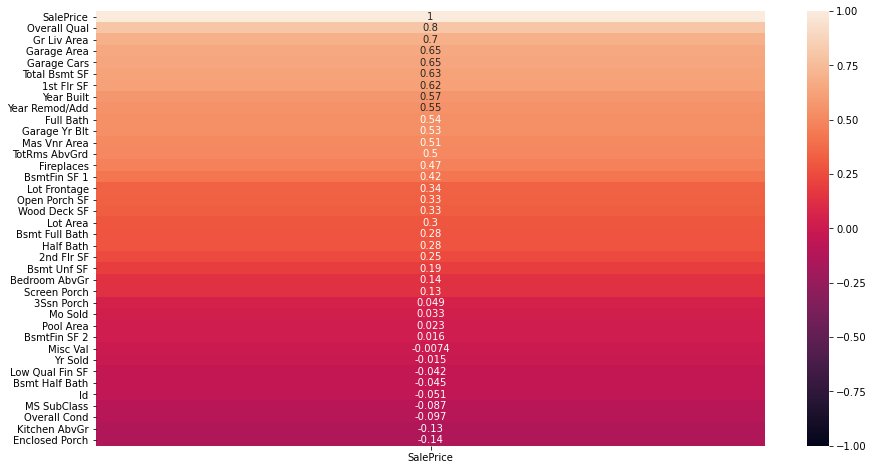

In [262]:
plt.figure(figsize=(15,8))
# plotting correlation of variables of interest
corr = df_train.corr()[['SalePrice']]
sns.heatmap(
    data=corr.sort_values('SalePrice',ascending =False),
    vmin=-1, vmax=1, 
    annot=True);

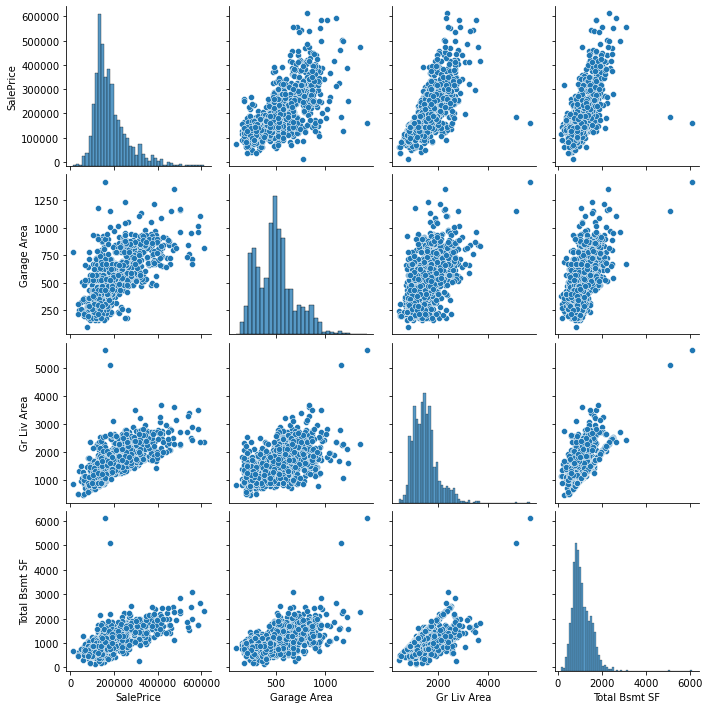

In [10]:
sns.pairplot(df_train[['SalePrice', 'Garage Area', 'Gr Liv Area', 'Total Bsmt SF']])

#### SLR Model

In [252]:
y = df_train['SalePrice']
X = df_train[['Total Bsmt SF']] #df_train.drop(columns=['Sales']) #be sure to exclude all other variables revolving around sales 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11)

In [13]:
lr = LinearRegression() #instantiating model 

In [14]:
cross_val_score(lr, X_train, y_train, cv =5)

array([0.4970426 , 0.28654033, 0.53495209, 0.4407776 , 0.46039835])

In [15]:
lr.fit(X_train, y_train)  
#This is where we fit the model - where the relationship between our X and y and line of best fit is determined - aka it's estimating the parameters of the model (our Betas) 

LinearRegression()

In [16]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.4508550310880133, 0.2594107108416025)

#### Now we have a model object, and we can run our test data through it

In [17]:
#Recall test dataframe
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [18]:
df_test.shape

(878, 80)

In [19]:
df_test['Total Bsmt SF'].isnull().sum(), df_test['Garage Area'].isnull().sum(), df_test['Gr Liv Area'].isnull().sum()

(0, 0, 0)

In [20]:
X_test_set = df_test[['Total Bsmt SF']]

In [21]:
df_test['y_hat'] = lr.predict(X_test_set)

In [22]:
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,y_hat
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD,175904.684017
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,301162.839345
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,127494.457143
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD,169026.728287
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD,225373.057927


#### Now we have a crappy-ish model and want to make a submission!

In [25]:
#this is the format we want our submissions to be in: 

sample_sub = pd.read_csv('./data/sample_sub_reg.csv')

In [26]:
sample_sub.head() 

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217
2,6,181479.1217
3,7,181479.1217
4,17,181479.1217


In [27]:
my_crappy_submission = pd.DataFrame({'Id' : df_test['Id'],
                           'SalePrice' : df_test['y_hat']})


In [28]:
my_crappy_submission.head()

,Id,SalePrice
0,2658,175904.684017
1,2718,301162.839345
2,2414,127494.457143
3,1989,169026.728287
4,625,225373.057927


In [29]:
my_crappy_submission.shape

(878, 2)

In [30]:
my_crappy_submission.to_csv('crappy_submission.csv', index=False)